# Assignment 4

* Ryan Rickgauer
* z1729300
* 4/6/20129
* [dataset](https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv)

Initial import statements and a function that retrieves the dataset and splits it into test and training data.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def getData():
    rawData = pd.read_csv("https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv", sep=';')
    X = pd.read_csv("https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv", sep=';')
    y = pd.read_csv("https://raw.githubusercontent.com/pratoolbharti/Applied_Machine_Learning_S20/master/Data-HW4/winequality-white.csv", sep=';')
    X.drop(columns='quality', axis=1, inplace=True)
    y = y['quality']
    return train_test_split(X, y, random_state = 0)

# Question 1

*Train a Random Forest Regressor for the dataset. Find the best model based on R-squared value using RandomizedSearchCV.*

Initial training of the random forest regressor

In [7]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = getData()
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.45104433297503865


Fine tune the model by using RandomizedSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestRegressor()
distributions = dict(n_estimators = np.arange(1, 101, 10), max_features = ['auto', 'sqrt', 'log2'])
model = RandomizedSearchCV(forest, distributions, random_state=0)
search = model.fit(X_train, y_train)

Update parameters.

In [12]:
params = search.best_params_
forest = RandomForestRegressor(n_estimators=params['n_estimators'], max_features=params['max_features'])
forest.fit(X_train, y_train)
score = cross_val_score(forest, X_train, y_train, cv=20, scoring='r2').mean()
print(score)

0.5289386016960521


# Question 2

*Use the best model from question 1 for model interpretation and rank the features based on **drop feature importance**.*

Get the feature importances based on drop feature method.

In [0]:
from sklearn.base import clone 

importances = []    # list of feature importances

# iterating over all columns and storing feature importance (difference between benchmark and new model)
for col in X_train.columns:
    # clone the original model
    model_clone = clone(forest)

    # drop one of the columns to determine its importance
    X_train_drop = X_train.drop(col, axis = 1)

    # fit the model to the new data
    model_clone.fit(X_train_drop, y_train)

    # get the cross validated score of the new data model
    drop_col_score = cross_val_score(forest, X_train_drop, y_train, cv=20, scoring='r2').mean()

    # append the difference between the original score and the new score to the list
    difference = score - drop_col_score
    importances.append(difference)

print(importances)

[0.001299371791802728, 0.010353209954936604, 0.002210816917640468, -0.000575482019423923, 0.0031202546147180987, 0.028249595467440325, 0.0017385262114980593, 0.004444374387273742, 0.0021179000013517024, 0.0036773984174842678, 0.01415238608701197]


Graph the feature importances.

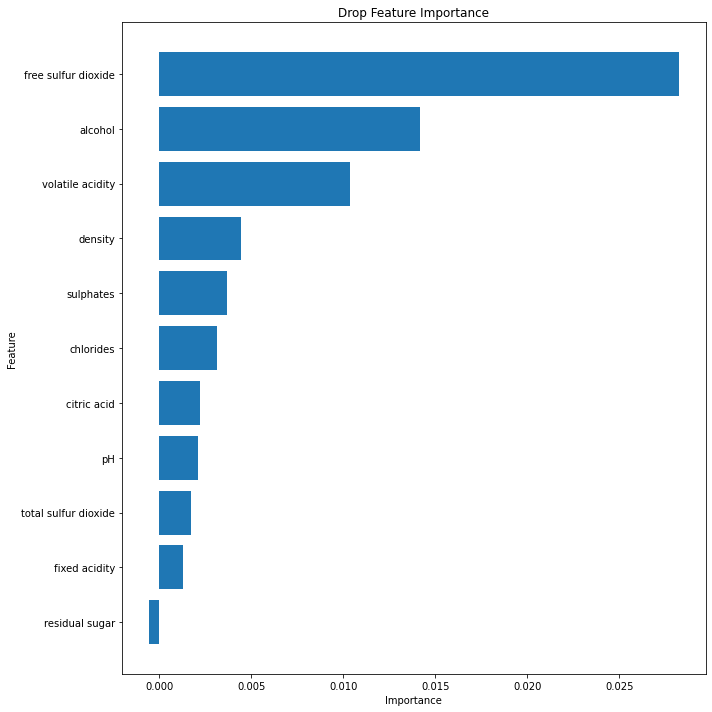

In [0]:
df_importances = pd.DataFrame()
df_importances['feature'] = X_train.columns
df_importances['importance'] = importances
df_importances.sort_values(by=['importance'], inplace=True, ascending=True)     # sort the data by highest ranked feature

plt.barh(df_importances['feature'].values, df_importances['importance'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Drop Feature Importance')
plt.tight_layout()
plt.show()

# Question 3

*Use the best model from question 1 for model interpretation and randk the features based on **permutation importance**.*

Import the eli5 package to use the Permutation Importance method.

In [0]:
%%capture
!pip install eli5
from eli5.sklearn import PermutationImportance

Get the importances based on the permutation importance method.

In [0]:
perm = PermutationImportance(forest, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)

Graph the results.

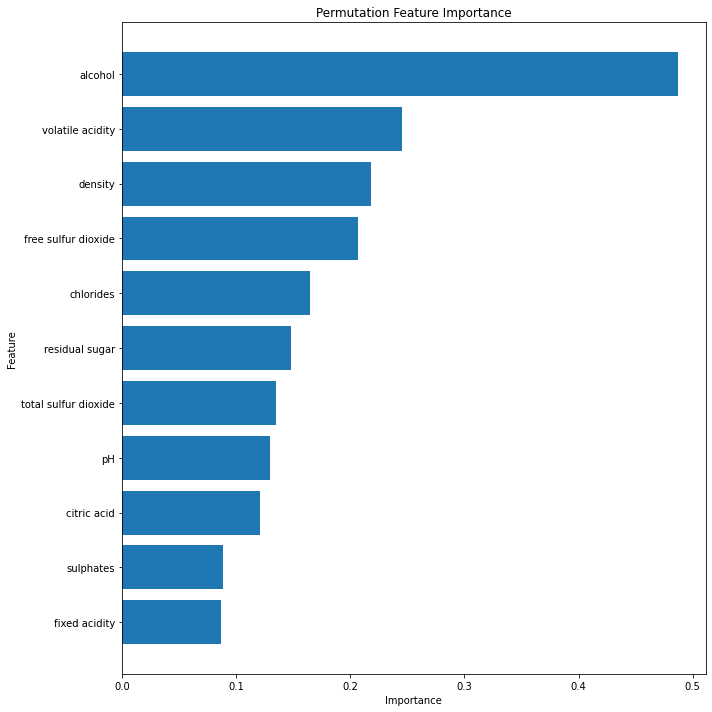

In [0]:
perm_importances = pd.DataFrame()
perm_importances['feature'] = X_train.columns
perm_importances['importance'] = perm.feature_importances_
perm_importances.sort_values(by=['importance'], inplace=True, ascending=True)     # sort the data by highest ranked feature

plt.barh(perm_importances['feature'].values, perm_importances['importance'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

# Question 4

*Use the best model from question 1 for model interpretation and rank the features based on **SHAP algorithm**.*

Install the shap package from pip.

In [0]:
%%capture
!pip install shap;
import shap

Get the importance of the features by using the shap method.

In [0]:
shap_values = shap.TreeExplainer(forest).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Graph the results.




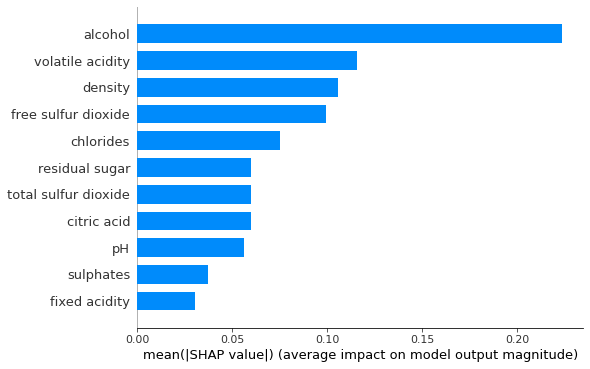

In [0]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Question 5

*Visualize partial dependence plot for each feature in the dataset using Sklearn*

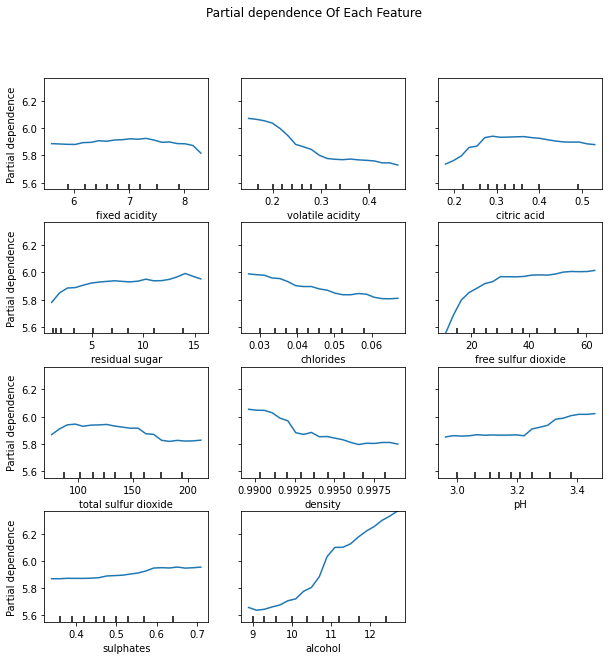

In [0]:
from sklearn.inspection import plot_partial_dependence
features = X_train.columns
plot_partial_dependence(forest, X_train, features, n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence Of Each Feature')
fig.subplots_adjust(hspace=0.3)

# Question 6

*Visualize ICE plot for each feature using the [following library](http://austinrochford.github.io/PyCEbox/).*

Download pycebox

In [0]:
%%capture
!pip install pycebox
from pycebox.ice import ice, ice_plot

Graph the results

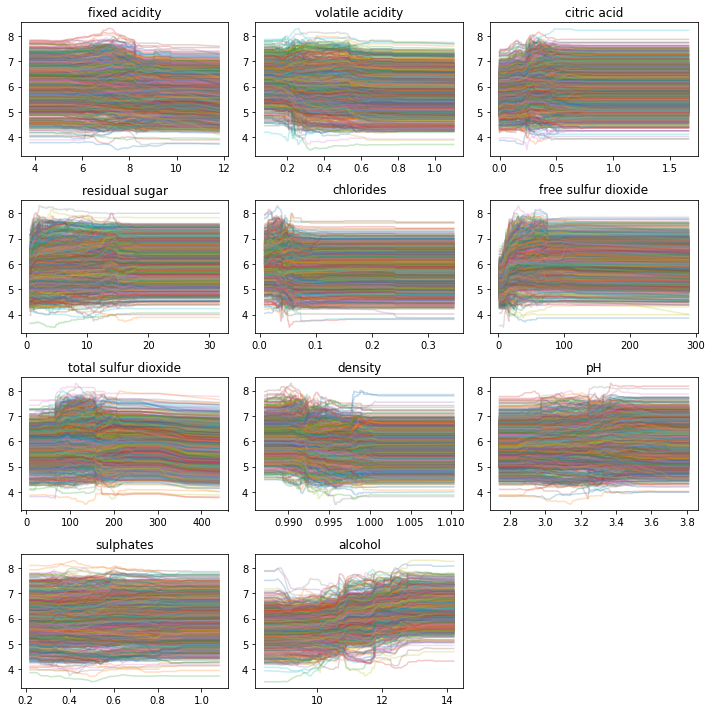

In [0]:
def plotIce(column_name, axs, model):
    ice_df = ice(X_train, column_name, model.predict)
    ice_plot(ice_df, alpha=0.25, ax=axs)

fig, axs = plt.subplots(4, 3)
fig.delaxes(axs[3, 2])
column_names = X_train.columns

for count in range(11):
    plotIce(column_names[count], axs.flat[count], forest)
    axs.flat[count].set_title(column_names[count])

plt.tight_layout()

# Question 7

*Analyze outputs from each technique and comment that which technique you found most useful and why.*

I found that the most useful technique was the Permutation Method. It was the quickest one to implement and gave me results without having to do too much work.  